# Stabilität von kreisförmigen Bögen

Hier wollen wir die kritische Belastung sowie das Nachbeulverhalten von kreisförmigen Bögen berechnen. 

<img src="circularArchPressure.png" alt="Arch" style="display:block; margin:auto;">
<div style="text-align:center; font-size:90%;">Abb. 1: Kreisförmiger Bogen unter radialer Linienlast</div>

Wird dieser, wie in Abb.1, mit einer konstanten, radialen Linienlast belastet existiert eine analytische Lösung. Der Bogen knickt bei
\begin{equation}
    p_k = \frac{EI_y}{R^3}\left(\frac{\pi^2}{\alpha^2} - 1\right)
\end{equation}
aus. Ein derartiger Lastfall war im Schiffsbau von großer Bedeutung.

In [40]:
# libraries
from GeoNonlinear_FEM_lib import GNLexamples, FEMsolve, ANSYS, B2D_LR, B2D_SR_ML, B2D_SR
import numpy as np
import matplotlib.pyplot as plt

# critical load
def p_k(E,I,R,alpha):
    return (E*I/R**3)*(np.pi**2/alpha**2 - 1)

### Finite-Elemente Berechnung

#### Systemparameter

In [41]:
R = 40.0                    # Radius des Bogens in m
alpha = 20/180*np.pi        # Halber Öffnungswinkel in rad
E = 2.1E11                  # Elastizitätsmodul in Pa
nu = 0.3                    # Querkontraktionszahl
b = 0.1                     # Breite des Querschnitts in m
h = 0.2                     # Höhe des Querschnitts in m
I = b * h**3 / 12           # Flächenträgheitsmoment in m^4

#### Diskretisierung

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


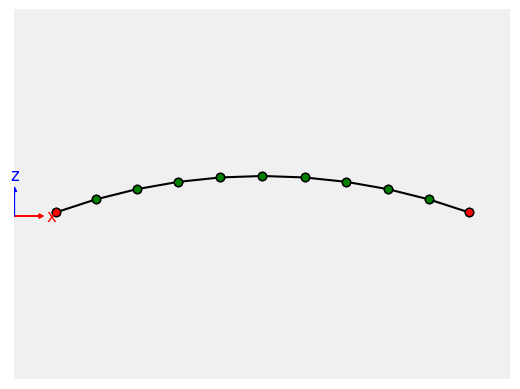

In [64]:
pk = p_k(E,I,R,alpha)
F0 = 0.1*pk
mesh = GNLexamples.shallowArch(loadCase = "pressure", n = 10, R = R, alpha = alpha, F = F0, b = b, h = h, elType = B2D_SR_ML)
mesh.plotMesh()

#### Lösen und Darstellung der Ergebnisse

Es wird die Belastung inkrementweise aufgebracht und der Gleichgewichtszustand für die Referenzbelastung ermittelt.

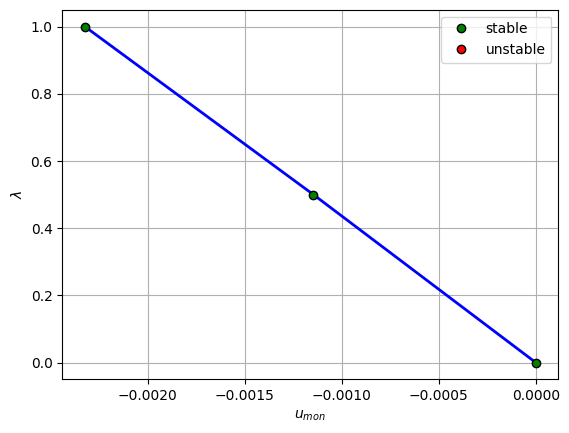

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


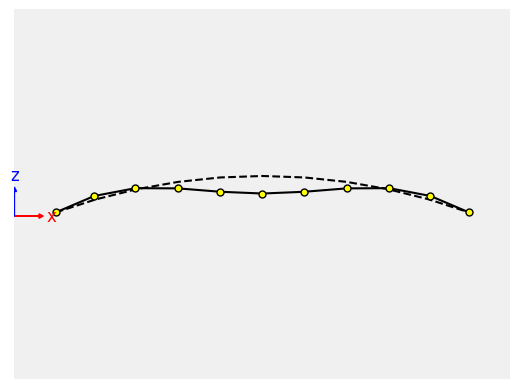

(<matplotlib.lines.Line2D at 0x20e458c4910>,)

In [65]:
# Berechung der nichtlinearen Strukturantwort
sol = FEMsolve.LoadCon(mesh, numInc = 2)
# plot der Last-Verformungskurve (Vertikalverschiebung des Scheitels)
sol.plotMonitor()
# plotten der Verschiebung
mesh.plotDisplacement(sol.u, scale = 500)

### Lineare Beulanalyse

Von dem vorhin ermittelten Gleichgewichtszustand wird eine lineare Beulanalyse durch Lösen des verallgemeinerten Eigenwertproblems
$$
\left( \mathbf{K}_{r} + \Delta \lambda_i \, \mathbf{K}_{g} \right) \boldsymbol{\varphi}_i = \mathbf{0}
$$
durchgeführt. Der Beulmode $\boldsymbol{\varphi}_i$, der zum kleinsten Eigenwert $\Delta \lambda_i $ gehört wird nachfolgend geplottet und die kritische Belastung wird berechnet und ausgegeben.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


p_k = 18121.2 N/m


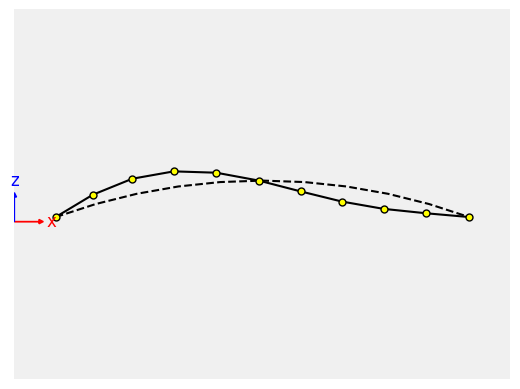

(<matplotlib.lines.Line2D at 0x20e45878410>,)

In [66]:
# Lineare Beulanalyse
buckling = FEMsolve.linBuckling(mesh, sol.u, numModes = 1)
# Lineare Beulanalyse
buckling = FEMsolve.linBuckling(mesh, sol.u, numModes = 1)
print(f"p_k = {F0 * buckling.LambdaCrit[0]:5.1f} N/m")
# plotten des ersten Beulmode
mesh.plotDisplacement(buckling.buckModes[:,0], scale = 1)

Die Form des Beulmodes ist typisch für einen Verzweigungspunkt. Dieser bricht in diesen Fall die Symmetrie des Verschiebungsfeldes.

### Konvergenzstudie

Nachfolgend wird eine Konvergenzstudie für die kritisch Belastung durchgeführt, durch Erhöhung der Elementzahl. 

In [67]:
# Anzahl der Elemente für Konvergenzstudie
nEl = np.array([2, 4, 6, 8, 10, 12, 14], dtype=int)

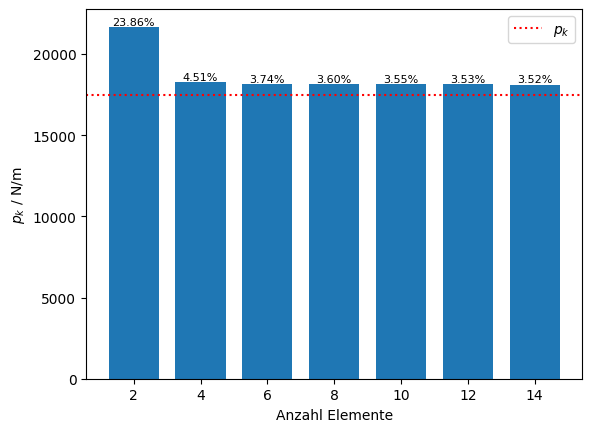

In [68]:
# Konvergenzstudie
# Referenzbelastung
Fr = 1E-1*pk

lambdaCrit = []

for n in nEl:
    # create mesh
    mesh = GNLexamples.shallowArch(loadCase="pressure", n=n, R=R, alpha=alpha, F=Fr, b=b, h=h, elType=B2D_SR_ML)
    # solve
    sol = FEMsolve.LoadCon(mesh, numInc=2)
    # linearized buckling analysis
    buckling = FEMsolve.linBuckling(mesh, sol.u, numModes=1)
    # store critical load factor
    lambdaCrit.append(buckling.LambdaCrit[0])

# plot results
results = np.array([nEl, Fr * np.array(lambdaCrit)]).T
rel_error = (results[:,1] - pk) / pk

bars = plt.bar(results[:,0], results[:,1], width=1.5)
plt.axhline(pk, color='r', linestyle=':', label='$p_k$')
plt.xlabel('Anzahl Elemente')
plt.ylabel('$p_k$ / N/m')

for bar, err in zip(bars, rel_error):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{err:.2%}', ha='center', va='bottom', fontsize=8)

plt.legend()
plt.show()